In [2]:
import json
import numpy as np
import pandas as pd
import webp
from PIL import Image
import os
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [3]:
annots = json.loads(open('ImageDataset_json.json','r').read())

In [4]:
annots['img_00.jpeg21788']

{'filename': 'img_00.jpeg',
 'size': 21788,
 'regions': [{'shape_attributes': {'name': 'rect',
    'x': 181,
    'y': 7,
    'width': 91,
    'height': 61},
   'region_attributes': {'name': 'hardhat',
    'type': 'unknown',
    'image_quality': {'good': True,
     'frontal': True,
     'good_illumination': True}}},
  {'shape_attributes': {'name': 'rect',
    'x': 196,
    'y': 66,
    'width': 65,
    'height': 59},
   'region_attributes': {'name': 'mask',
    'type': 'unknown',
    'image_quality': {'good': True,
     'frontal': True,
     'good_illumination': True}}},
  {'shape_attributes': {'name': 'rect',
    'x': 128,
    'y': 126,
    'width': 191,
    'height': 72},
   'region_attributes': {'name': 'vest',
    'type': 'unknown',
    'image_quality': {'good': True,
     'frontal': True,
     'good_illumination': True}}}],
 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}

In [5]:
region_annots = pd.DataFrame(columns=['file_name', 'region', 'x', 'y', 'width', 'height'],index=[])
for k in annots:
    file_name = annots[k]['filename']
    for region in annots[k]['regions']:
        region_annots.loc[len(region_annots.index)] = [file_name,region['region_attributes']['name'].replace("\n", ""),region['shape_attributes']['x']
                   ,region['shape_attributes']['y'],region['shape_attributes']['width'],region['shape_attributes']['height']]
region_annots.sample(5)

,file_name,region,x,y,width,height
179,img_42.jpeg,vest,63,43,61,112
189,img_45.jpg,hardhat,106,62,90,40
197,img_48.jpg,hardhat,346,59,68,65
24,img_08.jpeg,hardhat,182,125,52,27
192,img_46.jpg,vest,677,426,547,532


In [6]:
image_dims = pd.DataFrame(columns=['file_name', 'width', 'height'],index=[])
folder = 'images/'
for file_name in os.listdir(folder):
#     print(file_name)
    try:
        img = Image.open(folder+file_name)
        image_dims.loc[len(image_dims.index)] = [file_name,img.size[0], img.size[1]]
    finally:
        continue

In [7]:
len(image_dims)

50

In [8]:
data = region_annots.merge(image_dims, on = ['file_name'],suffixes=['_reg','_img'])
data.sample(5)

,file_name,region,x,y,width_reg,height_reg,width_img,height_img
39,img_09.jpg,mask,770,354,57,20,940,788
53,img_10.jpeg,mask,44,72,72,73,600,420
153,img_33.jpeg,hardhat,182,8,62,59,390,280
35,img_09.jpg,hardhat,183,456,51,27,940,788
114,img_23.jpeg,vest,650,298,144,93,800,568


In [9]:
data['width_normalized'] = data['width_reg'].div(data['width_img'])
data['height_normalized'] = data['height_reg'].div(data['height_img'])

In [10]:
data.sample(5)

,file_name,region,x,y,width_reg,height_reg,width_img,height_img,width_normalized,height_normalized
44,img_10.jpeg,hardhat,2,2,122,64,600,420,0.203333,0.152381
113,img_23.jpeg,vest,436,148,93,136,800,568,0.11625,0.239437
188,img_45.jpg,hardhat,315,103,112,68,800,450,0.14,0.151111
53,img_10.jpeg,mask,44,72,72,73,600,420,0.12,0.17381
50,img_10.jpeg,vest,348,265,76,96,600,420,0.126667,0.228571


In [11]:
cluster_data = data[['width_normalized','height_normalized']]

In [12]:
cluster_data.sample(5)

,width_normalized,height_normalized
188,0.14,0.151111
102,0.318627,0.564516
192,0.364667,0.483197
154,0.307692,0.625
176,0.386111,0.317361


In [88]:
height =  cluster_data['height_normalized']
width  = cluster_data['width_normalized']
mean_iou = []
for k in range(2,6):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300)
    kmeans.fit(cluster_data)
    iou = 0
    for i in range(len(kmeans.labels_)):
        cx,cy = kmeans.cluster_centers_[kmeans.labels_[i]]
        iou += min(width[i] ,cx)* min(height[i] , cy)/(height[i]*width[i]+ cx*cy- min(width[i] , cx)* min(height[i] ,cy))
    mean_iou.append(iou/50.)

In [89]:
mean_iou

[2.050679024204221, 2.1992677311120175, 2.4128631078500415, 2.4465478017917124]

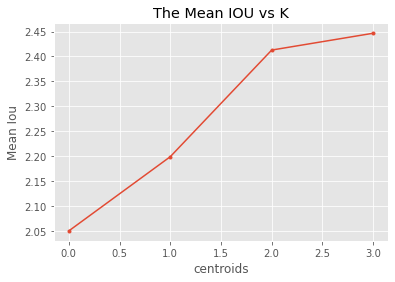

In [90]:
plt.style.use('ggplot')
plt.title('The Mean IOU vs K')
plt.plot(mean_iou,'.-',label = "iou")
plt.xlabel('centroids')
plt.ylabel('Mean Iou')
plt.show()

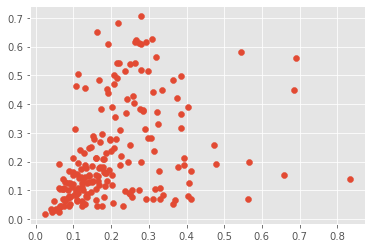

In [91]:
plt.scatter(cluster_data['width_normalized'], cluster_data['height_normalized'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


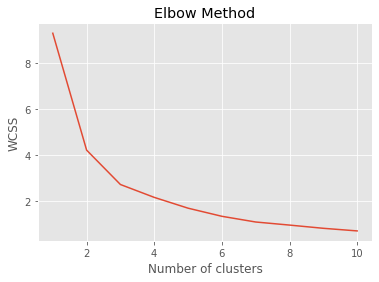

In [92]:
wcss = []
#OMP_NUM_THREADS=1
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cluster_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

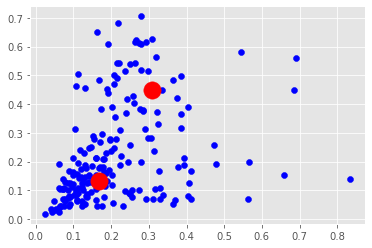

In [94]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(cluster_data)

plt.scatter(cluster_data['width_normalized'], cluster_data['height_normalized'],c='blue')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

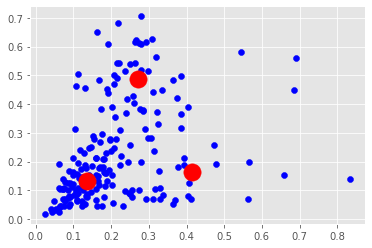

In [96]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(cluster_data)

plt.scatter(cluster_data['width_normalized'], cluster_data['height_normalized'],c='blue')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

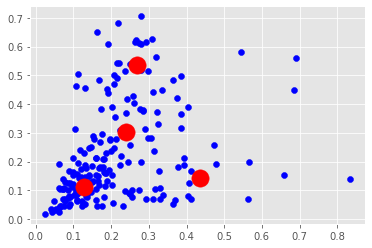

In [98]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(cluster_data)

plt.scatter(cluster_data['width_normalized'], cluster_data['height_normalized'],c='blue')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()